In [1]:
import torch, torch.nn as nn

from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset, Subset, random_split
import torch.nn.functional as F
import torch.optim as optim

In [2]:
import torchinfo

In [3]:
import numpy as np
import pandas as pd

In [4]:
import time
from tqdm import tqdm

In [5]:
from pandas.api.types import is_object_dtype

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
import matplotlib.pyplot as plt
import scienceplots

plt.style.use('science')
%config InlineBackend.figure_format = 'retina'

In [8]:
TARGET_COL = 'price'

In [9]:
TRAIN_SZ = 0.8
SEED_SPLITTING = 42

### Load data

In [10]:
data_path = '../data/cars_dataset_new_v2.csv'

In [46]:
cars_df = pd.read_csv(data_path, index_col=0)
n_rows, _ = cars_df.shape
print(f'DF shape: {cars_df.shape}')

cars_df['price'] = cars_df['price'] / 1e6  # NORMALIZE PRICE TO MILLIONS!

pd.set_option('display.max_columns', None)
cars_df.sample(3)

DF shape: (22702, 29)


,box,drive_unit,seats,doors,country,volume,mileage,price,year,car_type,drive,boost_type,width,diemeter,length,car_class,height,fuel,torque,valves_per_cylinder,clearance,maximum_speed,transmissions,full_weight,compression_ratio,consumption,restyling,trunk_volume_max,trunk_volume_min
33654,automatic,rear,5.0,4.0,Japan,3.0,228600.0,0.41,1999.0,Sedan,rear,no,1800.0,86.0,4805.0,E,1180.0,AI-95,304.0,4.0,150.0,197.156414,4.0,2118.954231,10.5,10.6,0.0,515.0,0.0
25805,mechanics,front,5.0,5.0,Russia,1.6,92000.0,0.22,2012.0,Hatchback,front,no,1700.0,82.0,3850.0,B,1500.0,AI-95,145.0,4.0,160.0,183.000000,5.0,1555.000000,10.3,7.2,0.0,235.0,0.0
32765,automatic,full,5.0,5.0,Japan,2.0,406000.0,0.30,2001.0,SUV,full,no,1680.0,81.5,4035.0,J,1700.0,AI-95,190.0,4.0,200.0,165.000000,4.0,1890.000000,11.0,0.0,0.0,358.0,1158.0


In [12]:
cat_cols = []
num_cols = []

for column_name in cars_df.columns:  # find all categorical and numerical columns
    if not column_name == TARGET_COL:
        if is_object_dtype(cars_df[column_name]):
            cat_cols.append(column_name)
        else:
            num_cols.append(column_name)

print(f'Categorical ({len(cat_cols)}):')
print(*cat_cols, sep=', ', end='\n\n')
print(f'Numerical ({len(num_cols)}):')
print(*num_cols, sep=', ')

Categorical (8):
box, drive_unit, country, car_type, drive, boost_type, car_class, fuel

Numerical (20):
seats, doors, volume, mileage, year, width, diemeter, length, height, torque, valves_per_cylinder, clearance, maximum_speed, transmissions, full_weight, compression_ratio, consumption, restyling, trunk_volume_max, trunk_volume_min


In [13]:
print('Count NaN values in TRAIN:')
for column_name in cars_df.columns:  # count nan values by columns
    nans = cars_df[column_name].isna().sum()
    if nans > 0:  # if there is NaN's in column `column_name`
        print(f"\t{column_name + (25 - len(column_name)) * ' '}{nans}",end='')
        if column_name in cat_cols:
            print('\t(cat)')
        else:
            print('\t(num)')

Count NaN values in TRAIN:
	drive                    191	(cat)
	boost_type               283	(cat)
	car_class                221	(cat)
	fuel                     419	(cat)


### Dataset and data splitting

In [101]:
NUM_CAT_COLS = ['doors', 'seats', 'valves_per_cylinder', 'restyling']  # categorical features with numbers!

In [108]:
class CarsDataset(Dataset):

    def __init__(
        self, 
        df, target_name=TARGET_COL,
        num_train_means=None, num_train_vars=None,
        cat_train_most_freq=None,
        cat_all_unique=None,
        cat_embeddings=None,
        num_transform=True,
        train_ratio=TRAIN_SZ, split_seed=SEED_SPLITTING
    ):
        '''
        Args:
            df: DataFrame - dataframe of cars
            target_name: str - target column name

            num_train_means, num_train_vars: dicts - dictianories with mean and var (by train set) for numerical features (key - column name)
            cat_most_freq: dict - most frequent values for categorical columns (key - column name)
            cat_all_unique: dict - unique values arrays by categorical columns (key - column name)
            
            num_transform: boolean - flag to transform numerical features
            
            train_ratio: float - part of data (< 1) to use as train set (the rest of data (1 - train_ratio) - test set) 
            split_seed: int - random seed for splitting data
        '''
        self.df = df.copy()
        self.target_name = target_name
        
            # statistics for numerical features
        self.num_train_means, self.num_train_vars = num_train_means, num_train_vars
            # statistics for categorical features
        self.cat_train_most_freq = cat_train_most_freq
        self.cat_all_unique = cat_all_unique

                    # data splitting
        self.split_seed = split_seed
        self.train_ratio = train_ratio  # for data splitting
        
        self.num_transform = num_transform
            # 
        self.df_splitting_and_stats()
        self.df_transform()

    def df_splitting_and_stats(self):
            # data splitting
        n_all_cars = len(self.df)  # numer of all cars

        if self.train_ratio is not None:
            self.train_ids, self.test_ids = train_test_split(
                np.arange(n_all_cars),  # array of all indecies of cars
                train_size=self.train_ratio, 
                random_state=self.split_seed  # can be None
            )
        else:
            self.train_ids = np.arange(n_all_cars)
            self.test_ids = None
        
            # statistics
        self.cat_cols = []  # categorical columns names
        self.num_cols = []  # numerical columns names

        for column_name in self.df.columns:  # find all categorical and numerical columns
            if not column_name == self.target_name:
                if is_object_dtype(self.df[column_name]):
                    self.cat_cols.append(column_name)
                else:
                    if not column_name == self.target_name:  # not a target column!
                        self.num_cols.append(column_name)

            # numerical columns statistics (if not predefined)
        if (self.num_train_means is None) and (self.num_train_vars is None):
            self.num_train_means = {}
            self.num_train_vars = {}  # means and vars for numeric features calculated for train set!

            for num_column_name in self.num_cols:
                # TODO: check for NaN's
                if num_column_name not in NUM_CAT_COLS:
                    self.num_train_means[num_column_name] = self.df.iloc[self.train_ids][num_column_name].mean()
                    self.num_train_vars[num_column_name] = self.df.iloc[self.train_ids][num_column_name].var(ddof=0)
                else:
                    self.num_train_means[num_column_name] = 0.00
                    self.num_train_vars[num_column_name] = self.df[num_column_name].max()  # normalize numerical categorical by maximal value

            # categorical columns statistics
        if (self.cat_train_most_freq is None):
            self.cat_train_most_freq = {}
            for cat_column_name in self.cat_cols:
                self.cat_train_most_freq[cat_column_name] = self.df.iloc[self.train_ids][cat_column_name].mode().item()

        if (self.cat_all_unique is None):
            self.cat_all_unique = {}
            for cat_column_name in self.cat_cols:  # unique vals for df categorical!
                self.cat_all_unique[cat_column_name] = self.df[cat_column_name].unique()
                
    def df_transform(self):
            # fill NaN's for categorical features
        for cat_column_name in self.cat_cols:
                # use the column most frequent (by train part) value to replace NaN's in all data
            self.df[cat_column_name].fillna(self.cat_train_most_freq[cat_column_name], inplace=True)
        
        if self.num_transform:
            for num_column_name in self.num_cols:
                    # normalize all data set using the train set statistics
                self.df[num_column_name] = (self.df[num_column_name] - self.num_train_means[num_column_name]) / self.num_train_vars[num_column_name]
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, ind):
        '''
        Returns vector of numerical features and embedded categorical features
        '''
        item_features = torch.tensor(self.df.iloc[ind][self.num_cols])
        
        for cat_column_name in self.cat_cols:
            word_to_ix_this = {item:i for i, item in enumerate(self.cat_all_unique[cat_column_name])}
            
            torch.manual_seed(13)  # to fix embeddings!
            embed_this = nn.Embedding(len(word_to_ix_this), int(len(word_to_ix_this) / 2))
            
            feature_this_embedded = embed_this(
                torch.tensor(
                    word_to_ix_this[self.df.iloc[ind][cat_column_name]],
                    dtype=torch.long
                )
            )

            item_features = torch.cat((item_features, feature_this_embedded), dim=0)

        item_target = torch.tensor(self.df.iloc[ind][self.target_name], )
        
        return item_features.unsqueeze(0).to(torch.float32), item_target.unsqueeze(0).unsqueeze(0).to(torch.float32)

In [109]:
%%time
cars_ds = CarsDataset(df=cars_df)

CPU times: user 89 ms, sys: 23.2 ms, total: 112 ms
Wall time: 111 ms


In [110]:
INPUT_SZ = cars_ds[0][0].shape[1]
print(f'Input size for nn: {INPUT_SZ}')

Input size for nn: 52


#### Another dataset with quicker `__getitem__()`

In [111]:
# it takes quite a long time to get items from CarsDataset (every time nn.Embeddings must be created!)...
# let's prepare dataset with embedded categorical
col_names = cars_ds.num_cols.copy()
for cat_col_name in cars_ds.cat_cols: 
    for i in range(int(len(cars_ds.cat_all_unique[cat_col_name]) / 2)):
        col_names.append(f'{cat_col_name}_{i + 1}')
col_names.append(TARGET_COL)

df_for_nn = pd.DataFrame(columns=col_names)

for car_ind in tqdm(range(len(cars_df))):
    features_ind, target_ind = cars_ds[car_ind]
    
    this_values = torch.cat(
        (features_ind.squeeze(dim=0), target_ind.squeeze(dim=0)),
        dim=0
    ).unsqueeze(0).detach().numpy()
    
    row_df = pd.DataFrame(this_values, columns=col_names)

    df_for_nn = pd.concat([df_for_nn, row_df])

100%|████████████████████████████████████| 22702/22702 [00:45<00:00, 499.89it/s]


In [112]:
df_for_nn = df_for_nn.set_index(cars_df.index)

In [113]:
df_for_nn.head()

,seats,doors,volume,mileage,year,width,diemeter,length,height,torque,valves_per_cylinder,clearance,maximum_speed,transmissions,full_weight,compression_ratio,consumption,restyling,trunk_volume_max,trunk_volume_min,box_1,box_2,drive_unit_1,country_1,country_2,country_3,country_4,country_5,country_6,country_7,country_8,car_type_1,car_type_2,car_type_3,car_type_4,car_type_5,car_type_6,car_type_7,car_type_8,drive_1,drive_2,boost_type_1,boost_type_2,car_class_1,car_class_2,car_class_3,car_class_4,car_class_5,fuel_1,fuel_2,fuel_3,fuel_4,price
0,0.555556,1.0,0.518866,-0.000013,0.131675,0.012316,-0.093538,0.00166,0.014136,-0.010851,0.8,0.033755,0.001838,2.048173,0.004718,0.731219,0.199634,0.0,0.001868,0.001236,-0.111659,-1.14561,-0.111659,0.437159,0.370061,1.581573,-0.15564,0.151091,-1.349492,-0.708944,-0.243382,0.437159,0.370061,1.581573,-0.15564,0.151091,-1.349492,-0.708944,-0.243382,-0.111659,-1.14561,-0.111659,-1.14561,0.437159,0.370061,1.581573,-0.15564,0.151091,0.437159,0.370061,1.581573,-0.155640,12.9028
1,0.555556,1.0,0.518866,-0.000013,0.131675,0.012316,0.010883,0.00166,0.014136,0.017211,0.8,0.033755,0.012835,2.048173,0.004718,0.731219,0.184598,0.0,0.001868,0.001236,-0.111659,-1.14561,-0.111659,0.437159,0.370061,1.581573,-0.15564,0.151091,-1.349492,-0.708944,-0.243382,0.437159,0.370061,1.581573,-0.15564,0.151091,-1.349492,-0.708944,-0.243382,-0.111659,-1.14561,-0.111659,-1.14561,0.437159,0.370061,1.581573,-0.15564,0.151091,0.437159,0.370061,1.581573,-0.155640,15.7095
2,0.555556,1.0,1.522645,-0.000012,0.119448,0.012316,0.012156,0.00166,0.014136,0.013603,0.8,0.033755,0.012835,2.048173,0.004718,-0.110114,0.372544,0.0,0.001868,0.001236,-0.111659,-1.14561,-0.111659,0.437159,0.370061,1.581573,-0.15564,0.151091,-1.349492,-0.708944,-0.243382,0.437159,0.370061,1.581573,-0.15564,0.151091,-1.349492,-0.708944,-0.243382,-0.111659,-1.14561,-0.111659,-1.14561,0.437159,0.370061,1.581573,-0.15564,0.151091,0.151091,-1.349492,-0.708944,-0.243382,13.8900
3,0.555556,1.0,1.522645,-0.000013,0.131675,0.012316,0.012156,0.00166,0.014136,0.013603,0.8,0.033755,0.012835,2.048173,0.004718,-0.110114,0.372544,0.0,0.001868,0.001236,-0.111659,-1.14561,-0.111659,0.437159,0.370061,1.581573,-0.15564,0.151091,-1.349492,-0.708944,-0.243382,0.437159,0.370061,1.581573,-0.15564,0.151091,-1.349492,-0.708944,-0.243382,-0.111659,-1.14561,-0.111659,-1.14561,0.437159,0.370061,1.581573,-0.15564,0.151091,0.151091,-1.349492,-0.708944,-0.243382,13.1160
4,0.555556,1.0,1.522645,-0.000012,0.119448,0.012316,0.012156,0.00166,0.014136,0.013603,0.8,0.033755,0.012835,2.048173,0.004718,-0.110114,0.372544,0.0,0.001868,0.001236,-0.111659,-1.14561,-0.111659,0.437159,0.370061,1.581573,-0.15564,0.151091,-1.349492,-0.708944,-0.243382,0.437159,0.370061,1.581573,-0.15564,0.151091,-1.349492,-0.708944,-0.243382,-0.111659,-1.14561,-0.111659,-1.14561,0.437159,0.370061,1.581573,-0.15564,0.151091,0.151091,-1.349492,-0.708944,-0.243382,11.4500


In [122]:
# save dataframe for NN (with already normalized num features and embedded categorical features!)
FILEPATH_NN = '../data/cars_dataset_nn.csv'
# df_for_nn.to_csv(FILEPATH_NN)

In [123]:
# load dataset for NN
cars_for_nn_df = pd.read_csv(filepath, index_col=0)

In [166]:
class CarsDataset2(Dataset):

    def __init__(
        self, 
        df, target_name=TARGET_COL,
        transform_target=True,
        train_ratio=TRAIN_SZ, split_seed=SEED_SPLITTING
    ):
        self.df = df.copy()
        self.target_name = target_name
        
        self.transform_target = transform_target
            # data splitting
        self.split_seed = split_seed
        self.train_ratio = train_ratio  # for data splitting

        self.df_splitting()

    def df_splitting(self):
            # data splitting
        n_all_cars = len(self.df)  # numer of all cars

        if self.train_ratio is not None:
            self.train_ids, self.test_ids = train_test_split(
                np.arange(n_all_cars),  # array of all indecies of cars
                train_size=self.train_ratio, 
                random_state=self.split_seed  # can be None
            )
        else:
            self.train_ids = np.arange(n_all_cars)
            self.test_ids = None
            
        self.target_tr_mean = self.df.iloc[self.train_ids][self.target_name].mean()
        self.target_tr_var = self.df.iloc[self.train_ids][self.target_name].var(ddof=0)
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, ind):
        item_features = torch.tensor(self.df.iloc[ind][:-1])        
        item_target = torch.tensor(self.df.iloc[ind][-1])
        
        if self.transform_target:  # target normalization
            item_target = (item_target - self.target_tr_mean) / self.target_tr_var
        
        return item_features.unsqueeze(0).to(torch.float32), item_target.unsqueeze(0).unsqueeze(0).to(torch.float32)

In [167]:
%%time
cars_ds = CarsDataset2(df=cars_for_nn_df)

CPU times: user 13.2 ms, sys: 21.2 ms, total: 34.4 ms
Wall time: 35.7 ms


In [168]:
cars_ds.target_tr_mean  # mean price

1.348459554099444

In [169]:
cars_ds.target_tr_var  # variance for price

6.477178327283936

### Neural Network (fully connected)

In [170]:
print(f'Train size: {cars_ds.train_ids.shape[0]}')
print(f'Test size:  {cars_ds.test_ids.shape[0]}')

Train size: 18161
Test size:  4541


In [244]:
class NetCars(nn.Module):

    def __init__(self, input_dim=INPUT_SZ):
        super().__init__()
        self.input_dim = input_dim
        
#         self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(self.input_dim, 128)
        self.fc2 = nn.Linear(128, 16)
        self.fc3 = nn.Linear(16, 64)
        self.fc4 = nn.Linear(64, 64)
        self.fc5 = nn.Linear(64, 8)
        self.fc_out = nn.Linear(8, 1)

    def forward(self, x):
        # batch_size = x.size(0)
        
#         x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        out = self.fc_out(x)

        return out

In [245]:
# TORCHINFO
net_for_info = NetCars()

bs_info = 10

torchinfo.summary(net_for_info, 
                  (bs_info, INPUT_SZ),
                  device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
NetCars                                  [10, 1]                   --
├─Linear: 1-1                            [10, 128]                 6,784
├─Linear: 1-2                            [10, 16]                  2,064
├─Linear: 1-3                            [10, 64]                  1,088
├─Linear: 1-4                            [10, 64]                  4,160
├─Linear: 1-5                            [10, 8]                   520
├─Linear: 1-6                            [10, 1]                   9
Total params: 14,625
Trainable params: 14,625
Non-trainable params: 0
Total mult-adds (M): 0.15
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.06
Estimated Total Size (MB): 0.08

### Training and Evaluating

#### Training and Evaluating loops

In [190]:
def train_fn(model, data_loader, loss_func, optimizer,
             device='cpu', show_process=False):
    '''
    Function to train `model`
    Args:
        model: torch.nn.Module - Neural Network
        data_loader: torch.utils.data.DataLoader - loader (by batches) for the train dataset
        loss_func - loss function
        optimizer: torch.optim
        device: str - device to computate on
        show_process: bool - flag to show (or not) a progress bar
    Returns:
        mean loss by batches
    '''
    model.train()  # activate 'train' mode of a model
    train_loss = []  # to store loss for each batch

    for X, y in tqdm(data_loader, total=len(data_loader),
                     desc='train', position=0,
                     leave=True, disable=not show_process):   # [X, y] - batch
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        
        y_hat = model(X)

        loss = loss_func(y_hat, y)  # loss calculation for the batch
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())  # accumulate losses for batches

    return np.mean(train_loss)  # return mean loss of the epoch

In [191]:
def validate_fn(model, data_loader, loss_func,
                device='cpu', show_process=False):
    '''
    Function to train `model`
    Args:
        model: torch.nn.Module - Neural Network
        data_loader: torch.utils.data.DataLoader - loader (by batches) for the validation dataset
        loss_func - loss function
        device: str - device to computate on
        # scheduler: torch.optim.lr_scheduler - learning rate decreasing tool
        show_process: bool - flag to show (or not) a progress bar
    Returns:
          mean loss by batches
    '''
    model.eval()  # activate 'eval' mode of a model
    val_loss = []  # to store loss for each batch

    for X, y in tqdm(data_loader, total=len(data_loader),
                     desc='validation', position=0,
                     leave=True, disable=not show_process):   # [X, y] - batch
        X, y = X.to(device), y.to(device)

        with torch.no_grad():
            y_hat = model(X)
            loss = loss_func(y_hat, y)

        val_loss.append(loss.item())  # accumulate losses for batches

    return np.mean(val_loss)

#### DataLoaders

In [198]:
# DATA SPLITTING
train_ds = Subset(cars_ds, cars_ds.train_ids)
val_ds = Subset(cars_ds, cars_ds.test_ids)

# batches
train_bs = 250
val_bs = 1000

# DATALOADERS
train_loader = torch.utils.data.DataLoader(
    train_ds,
    batch_size=train_bs,
    shuffle=True,
#     num_workers=1,
    drop_last=False,
)
val_loader = torch.utils.data.DataLoader(
    val_ds,
    batch_size=val_bs,
    shuffle=False,
#     num_workers=1,
    drop_last=False,
)

#### Model

In [237]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [248]:
# MODEL
model = NetCars().to(device)

# Generate the optimizers
optimizer_name = 'Adam'  # fixed optimizer: 1 options ('Adam' can be checked) 

lr = 0.005  # can be selected too?
optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    factor=0.5,  # default: 0.1
    patience=5,  # default: 10
    verbose=False
)

loss_func = nn.L1Loss(reduction='sum')

In [249]:
n_epochs = 200
print_each = 5

start_time = time.time()
for epoch in range(n_epochs):
    start_epoch_time = time.time()
    if (epoch == 0) or ((epoch + 1) % print_each == 0):
        print(f'Epoch #{epoch + 1}: ', end='')
    mean_train_loss = train_fn(model, train_loader, loss_func,
                               optimizer,
                               device=device,
                               show_process=False
                              )  # train the model
    mean_val_loss = validate_fn(model, val_loader, loss_func,
                                device=device,
                                show_process=False
                               )  # evaluate the model
    if (epoch == 0) or ((epoch + 1) % print_each == 0):
        log_info = (f'\ttrain - {mean_train_loss / train_bs * cars_ds.target_tr_var:.6f}; ' +
                    f'\tval - {mean_val_loss / val_bs * cars_ds.target_tr_var:.6f}' + 
                    f'\t\ttime - {(time.time() - start_time):.3f} s'
                   )  # multiply loss by `price` variance to see absolute error in RUB!
        print(log_info)

    if scheduler:
        scheduler.step(mean_val_loss / val_bs)

Epoch #1: 	train - 0.771242; 	val - 0.610295		time - 2.930 s
Epoch #5: 	train - 0.486177; 	val - 0.429192		time - 17.560 s
Epoch #10: 	train - 0.405966; 	val - 0.370023		time - 36.134 s
Epoch #15: 	train - 0.366928; 	val - 0.343908		time - 53.762 s
Epoch #20: 	train - 0.340656; 	val - 0.320793		time - 71.024 s
Epoch #25: 	train - 0.336603; 	val - 0.370854		time - 88.025 s
Epoch #30: 	train - 0.292005; 	val - 0.289293		time - 104.885 s
Epoch #35: 	train - 0.293114; 	val - 0.302784		time - 121.792 s
Epoch #40: 	train - 0.269106; 	val - 0.271118		time - 138.767 s
Epoch #45: 	train - 0.263488; 	val - 0.269835		time - 155.757 s
Epoch #50: 	train - 0.258037; 	val - 0.269841		time - 172.662 s
Epoch #55: 	train - 0.254761; 	val - 0.264167		time - 189.699 s
Epoch #60: 	train - 0.250288; 	val - 0.261945		time - 206.752 s
Epoch #65: 	train - 0.250529; 	val - 0.259347		time - 223.764 s
Epoch #70: 	train - 0.237589; 	val - 0.253344		time - 240.716 s
Epoch #75: 	train - 0.235295; 	val - 0.249337		ti

In [228]:
# saving the model
model_path = 'nn/fc_model_52-128-128-64-64-32-1_Adam_l1-0.189.pth'
torch.save(model.state_dict(), model_path)

### Evaluating the model

In [250]:
class NetEvalCars(nn.Module):

    def __init__(self, input_dim=INPUT_SZ):
        super().__init__()
        self.input_dim = input_dim
        
        self.fc1 = nn.Linear(self.input_dim, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 32)
        self.fc_out = nn.Linear(32, 1)

    def forward(self, x):
        # batch_size = x.size(0)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        out = self.fc_out(x)

        return out

In [251]:
model_path_load = 'nn/fc_model_52-128-32-32-1_Adam_l1-0.189.pth'

In [252]:
model_test = NetEvalCars().to(device)

# LOAD MODEL
model_test.load_state_dict(torch.load(model_path_load))

<All keys matched successfully>

In [253]:
train_loader_test = torch.utils.data.DataLoader(
    train_ds,
    batch_size=len(train_ds),
    shuffle=True,
    drop_last=False,
)

val_loader_test = torch.utils.data.DataLoader(
    val_ds,
    batch_size=len(val_ds),
    shuffle=False,
    drop_last=False,
)

In [255]:
model_test.eval()  # activate 'eval' mode of a model

for X, y in train_loader_test:   # [X, y] - batch
    X, y = X.to(device), y.to(device)

    with torch.no_grad():
        y_hat_train = model(X) * cars_ds.target_tr_var + cars_ds.target_tr_mean
        y_train = y * cars_ds.target_tr_var + cars_ds.target_tr_mean
        
for X, y in val_loader_test:   # [X, y] - batch
    X, y = X.to(device), y.to(device)

    with torch.no_grad():
        y_hat_val = model(X) * cars_ds.target_tr_var + cars_ds.target_tr_mean
        y_val = y * cars_ds.target_tr_var + cars_ds.target_tr_mean

### Visualization

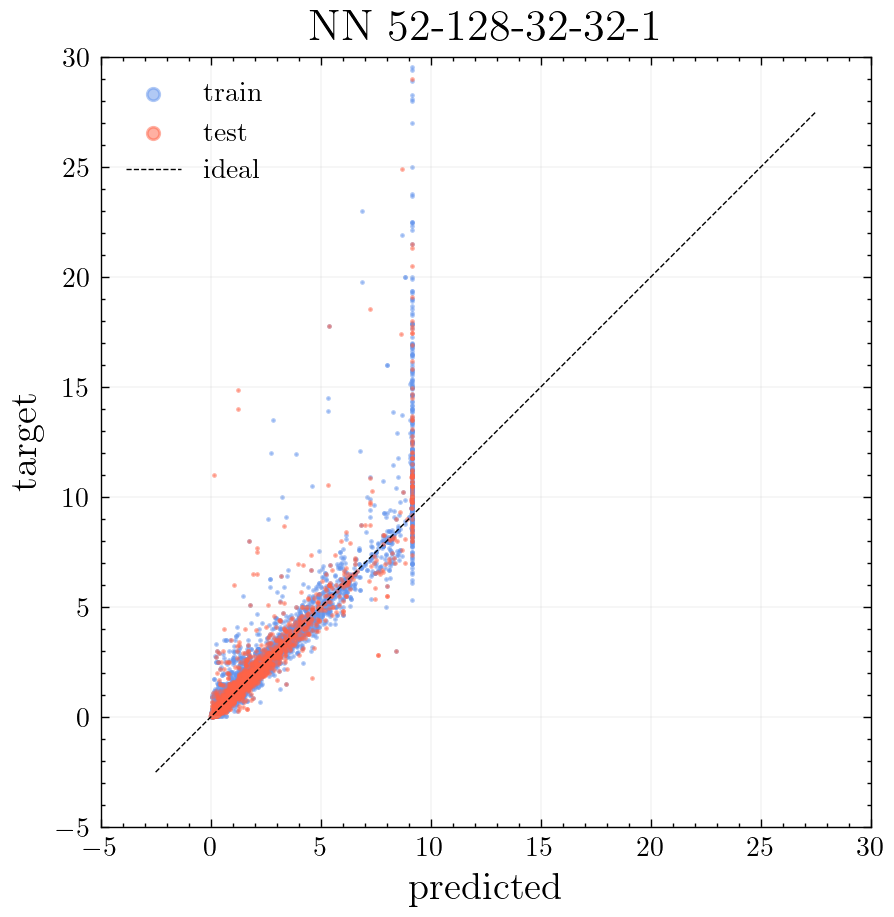

In [260]:
    # predictions visualization in matplotlib
lables_fs = 16
ticks_fs = 12

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
low_lim = -5
up_lim = 30  # some points 3-5 are out of the plot limits - outliers
delta = 2.5

ax.scatter(
    y_hat_train,
    y_train, 
    c='cornflowerblue', s=0.5,
    alpha=0.5,
    label='train'
)
ax.scatter(
    y_hat_val,
    y_val, 
    c='tomato', s=0.5, 
    alpha=0.5,
    label='test'
)

    # ideal predictor
ax.plot(
    [low_lim + delta, up_lim - delta],
    [low_lim + delta, up_lim - delta],
    c='k', linestyle='--', lw=0.50, 
    label='ideal'
)

ax.set_ylabel('target', fontsize=lables_fs - 2)
ax.set_xlabel('predicted', fontsize=lables_fs - 2)
ax.set_title('NN 52-128-32-32-1', fontsize=lables_fs)

ax.grid(color='silver', linestyle='-', linewidth=0.1)

ax.set(aspect='equal')
ax.set_xlim([low_lim, up_lim])
ax.set_ylim([low_lim, up_lim])

lgnd = ax.legend(loc='upper left')
for legend_handle in lgnd.legend_handles: legend_handle._sizes = [20]

plt.show()

### `shap`

In [262]:
import shap

In [296]:
%%time
X_train_nn = np.array(
    cars_for_nn_df.iloc[cars_ds.train_ids].drop(columns=[TARGET_COL])
)


e = shap.DeepExplainer(
    model_test, 
    torch.tensor(X_train_nn).to(torch.float32).to(device)
)

CPU times: user 26.7 ms, sys: 78.7 ms, total: 105 ms
Wall time: 52.6 ms


In [297]:
shap.DeepExplainer?

In [300]:
%%time
X_samples_nn = X_train_nn[np.random.choice(np.arange(len(X_train_nn)), 300, replace=False)]
print(len(X_samples_nn))

shap_values = e.shap_values(
    torch.tensor(X_samples_nn).to(torch.float32).to(device)
)

300


AssertionError: The SHAP explanations do not sum up to the model's output! This is either because of a rounding error or because an operator in your computation graph was not fully supported. If the sum difference of %f is significant compared to the scale of your model outputs, please post as a github issue, with a reproducible example so we can debug it. Used framework: pytorch - Max. diff: 2.8233540310829994 - Tolerance: 0.01

In [ ]:
shap_values.shape

In [ ]:
shap.summary_plot(shap_values, features=x_samples, feature_names=features)